In [1]:
import h5py
import cv2
from tqdm import tqdm
import torch
from matplotlib import pyplot as plt
import os, sys, numpy as np
import torch
from torch.utils.data import sampler, DataLoader
from skimage.transform import resize

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

from sononet.utils.util import json_file_to_pyobj
from sononet.models import get_model
from sononet.dataio.loader import get_dataset, get_dataset_path
from sononet.dataio.transformation import get_dataset_transformation
from sononet.utils.visualiser import Visualiser
from sononet.utils.error_logger import ErrorLogger
from sononet.models.networks_other import adjust_learning_rate

In [2]:
json_filename = 'configs/config_sononet_8_andi.json'
json_opts = json_file_to_pyobj(json_filename)
train_opts = json_opts.training

In [3]:
us_data = h5py.File('data/image_inp_224x288.hdf5')

In [4]:
cardiac_classes = [1, 2, 22, 29]

In [5]:
us_data['label_names'].value[cardiac_classes]

array([b'3VV', b'4CH', b'LVOT', b'RVOT'], dtype='|S16')

In [6]:
card_train_id = np.array([i in cardiac_classes for i in us_data['plane_labels_train'].value])
card_test_id = np.array([i in cardiac_classes for i in us_data['plane_labels_test'].value])

In [7]:
card_images_train = torch.tensor(us_data['images_train'][card_train_id,:,:,:])
card_labels_train = torch.tensor([{1: 0, 2:1, 22:2, 29:3}[lab] for lab in us_data['plane_labels_train'][card_train_id]])

card_images_test = torch.tensor(us_data['images_test'][card_test_id,:,:,:])
card_labels_test = torch.tensor([{1: 0, 2:1, 22:2, 29:3}[lab] for lab in us_data['plane_labels_test'][card_test_id]])

In [8]:
arch_type = train_opts.arch_type
ds_transform = get_dataset_transformation(arch_type, opts=json_opts.augmentation)



############# Augmentation Parameters #############
{'division_factor': (16, 16, 1),
 'inten_val': (1.0, 1.0),
 'name': 'us',
 'patch_size': [208, 272],
 'random_flip_prob': 0.5,
 'rotate_val': 15.0,
 'scale_size': (192, 192, 1),
 'scale_val': (0.7, 1.3),
 'shift_val': (0.1, 0.1)}
###################################################




In [9]:
class SimpleUSDataset(torch.utils.data.TensorDataset):
    def __init__(self, data, transform=None):
        super().__init__(*data)

        self.images = data[0]
        self.labels = data[1]

        self.label_names, lab_count = np.unique(self.labels, return_counts=True)
        self.n_class = len(self.label_names)
        self.weight = (1. / lab_count)[self.labels]
        
        # data augmentation
        self.transform = transform

    def __getitem__(self, index):

        indata  = self.images[index][0]
        target = self.labels[index]

        if self.transform:
            indata = self.transform(indata.numpy())
        return indata, int(target)

    def __len__(self):
        return len(self.images)

In [12]:
train_dataset = SimpleUSDataset(
    (card_images_train, card_labels_train),
    transform=ds_transform['train'])
train_dataset_for_acc = SimpleUSDataset(
    (card_images_train, card_labels_train),
    transform=ds_transform['valid'])
test_dataset = SimpleUSDataset(
    (card_images_test, card_labels_test),
        transform=ds_transform['valid'])

In [10]:
model = get_model(json_opts.model)


Initialising model sononet2
Network is initialized
sononet(
  (conv1): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv3): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(

In [13]:
batch_size = train_opts.batchSize
train_sampler = sampler.WeightedRandomSampler(train_dataset.weight, batch_size)

In [14]:
train_loader = DataLoader(train_dataset,
    num_workers=0,
    batch_size=batch_size,
    shuffle=True)
#    sampler=train_sampler)

train_loader_for_acc = DataLoader(train_dataset,
    num_workers=0,
    batch_size=batch_size,
    shuffle=False)

test_loader  = DataLoader(test_dataset,
    num_workers=0,
    batch_size=batch_size,
    shuffle=False)

In [15]:
import sys

def print_accuracy(model, fold):
    model.net.eval()
    if fold == 'train':
        loader = train_loader_for_acc
    elif fold == 'test':
        loader = test_loader
    labels = []
    preds = []
    for (img, lab) in loader:
        labels.append(lab.cpu())
        model.set_input(img)
        model.forward(split='test')
        preds.append(model.logits.cpu().argmax(dim=1))
    labels = torch.cat(labels)
    preds = torch.cat(preds)
    acc = (labels==preds).sum().float() / len(labels)
    print('Accuracy {fold}: {acc}'.format(
        fold=fold, acc=acc
    ))

In [16]:
model.set_labels([0,1,2,3])
model.set_scheduler(train_opts)
model.update_state(0)

opt.lr_policy = [step_warmstart]
Scheduler is added for optimiser SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.1
    lr: 0.010000000000000002
    momentum: 0.9
    nesterov: True
    weight_decay: 1e-06
)


In [17]:
for epoch in tqdm(range(1, 51)):
    for (images, labels) in train_loader:
        # Make a training update
        model.net.train()
        model.set_input(images, labels)
        model.optimize_parameters()

    if epoch % 5 == 0:
        model.save(epoch)
        print_accuracy(model, 'train')
        print_accuracy(model, 'test')

    if epoch == 25:
        model.update_learning_rate()

        #model.update_learning_rate(metric=valid_err, epoch=epoch)

8%|▊         | 4/50 [00:33<06:26,  8.41s/it]Saving the model S at the end of epoch 5
Accuracy train: 0.469453364610672
 18%|█▊        | 9/50 [01:27<06:30,  9.53s/it]Saving the model S at the end of epoch 10
Accuracy train: 0.5857449173927307
 28%|██▊       | 14/50 [02:23<06:01, 10.04s/it]Saving the model S at the end of epoch 15
Accuracy train: 0.6034297943115234
 38%|███▊      | 19/50 [03:21<05:20, 10.33s/it]Saving the model S at the end of epoch 20
Accuracy train: 0.6704180240631104
 48%|████▊     | 24/50 [04:20<04:34, 10.55s/it]Saving the model S at the end of epoch 25
Accuracy train: 0.6864951848983765
 50%|█████     | 25/50 [04:41<05:44, 13.79s/it]Accuracy test: 0.7625330090522766
current learning rate = 0.0100000
 58%|█████▊    | 29/50 [05:21<03:48, 10.89s/it]Saving the model S at the end of epoch 30
Accuracy train: 0.6012861728668213
 68%|██████▊   | 34/50 [06:23<02:55, 10.97s/it]Saving the model S at the end of epoch 35
Accuracy train: 0.6307609677314758
 78%|███████▊  | 39/50 

In [18]:
print_accuracy(model, 'test')

Accuracy test: 0.7308707237243652


In [19]:
def get_logits(model, fold):
    model.net.eval()
    with torch.no_grad():
        if fold == 'train':
            loader = train_loader_for_acc
        elif fold == 'test':
            loader = test_loader
        labels = []
        logits = []
        for (img, lab) in loader:
            labels.append(lab.cpu())
            model.set_input(img)
            model.forward(split='test')
            logits.append(model.logits.cpu())
        labels = torch.cat(labels)
        logits = torch.cat(logits)
        return logits, labels

In [21]:
foo, bar = get_logits(model, 'train')

In [22]:
from ptsne.ptsne import ParametricTSNE

In [23]:
ptsne = ParametricTSNE(4, 2, 50, use_cuda=True, hidden_layer_dims=[300,100], alpha=1)

In [24]:
ptsne.fit(foo, pretrain=True, verbose=True)

Calculating PCA
2020-03-11 15:55:49.713931: Beginning pretraining for 5 epochs
2020-03-11 15:55:50.012450: Loss after epoch 0: 20.50739085674286
2020-03-11 15:55:50.045451: Loss after epoch 1: 2.150400824844837
2020-03-11 15:55:50.079449: Loss after epoch 2: 0.4440266564488411
2020-03-11 15:55:50.114451: Loss after epoch 3: 0.44669415801763535
2020-03-11 15:55:50.150453: Loss after epoch 4: 0.4461640790104866
2020-03-11 15:55:50.151451: Finished pretraining
Indexing
2020-03-11 15:56:05.636434: Beginning training for 10 epochs
2020-03-11 15:56:05.749432: Loss after epoch 1: 14.164235582057287
2020-03-11 15:56:05.876433: Loss after epoch 2: 14.233238561947854
2020-03-11 15:56:05.992432: Loss after epoch 3: 13.389221617839103
2020-03-11 15:56:06.120433: Loss after epoch 4: 9.14759780089598
2020-03-11 15:56:06.238951: Loss after epoch 5: 6.303500629873731
2020-03-11 15:56:06.367952: Loss after epoch 6: 5.8343804273139375
2020-03-11 15:56:06.490951: Loss after epoch 7: 5.554536372655347
202

In [25]:
projected = ptsne(foo.cuda()).cpu().detach()

In [26]:
projected

tensor([[-50.1117, 240.8619],
        [-67.4667, 192.8265],
        [-50.2966, 275.6480],
        ...,
        [-58.6339, 247.1602],
        [-17.4522, 226.5607],
        [-32.8757, 232.1332]])

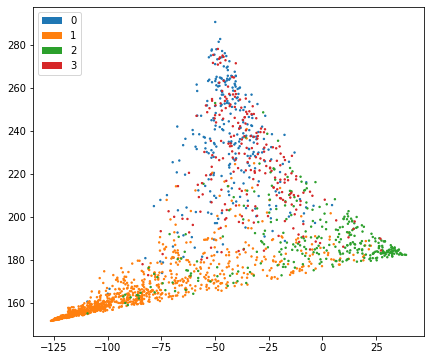

In [27]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in bar]
ax.scatter(projected[:,0], projected[:,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,4):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [114]:
foo.argmax(dim=1)[:100]

tensor([0, 3, 3, 0, 3, 3, 0, 0, 3, 3, 0, 1, 3, 0, 0, 3, 1, 3, 0, 2, 0, 2, 3, 1,
        2, 3, 1, 1, 0, 0, 3, 0, 0, 1, 0, 1, 3, 1, 0, 1, 1, 0, 1, 3, 3, 3, 1, 2,
        3, 1, 0, 0, 2, 0, 0, 3, 1, 0, 1, 1, 3, 3, 0, 3, 3, 0, 0, 1, 1, 1, 3, 1,
        3, 0, 3, 0, 0, 1, 3, 3, 3, 1, 0, 0, 1, 0, 1, 1, 1, 3, 1, 0, 3, 0, 2, 3,
        1, 3, 3, 0])

In [115]:
bar[:100]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])